<a href="https://colab.research.google.com/github/Nafiasulthana/Nafiasulthana/blob/main/WITHSMOTEENN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install shap
!pip install imbalanced-learn
!pip install xgboost
import shap
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, f1_score,
    precision_score, recall_score, matthews_corrcoef, log_loss
)
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from scipy.stats import randint, uniform















   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


In [5]:
# Load data
df_train = pd.read_csv(r'/content/customer_churn_dataset-training-master.csv')
df_test = pd.read_csv(r'/content/customer_churn_dataset-testing-master.csv')

In [6]:
df_train = df_train.dropna(subset=['Churn']).reset_index(drop=True)
y_train = df_train['Churn']
X_train = df_train.drop(columns=['Churn'])
X_test = df_test.copy()

if 'customerID' in X_train.columns:
    X_train = X_train.drop(columns=['customerID'])
    X_test = X_test.drop(columns=['customerID'])

cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['number']).columns.tolist()

target_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [7]:
models = {
    'RandomForest': (RandomForestClassifier(random_state=42), {
        'clf__n_estimators': randint(50, 150),
        'clf__max_depth': [None, 10]
    }),
    'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), {
        'clf__n_estimators': randint(50, 150),
        'clf__max_depth': [3, 6],
        'clf__learning_rate': uniform(0.05, 0.1)
    }),
    'LogisticRegression': (LogisticRegression(max_iter=1000, random_state=42), {
        'clf__C': uniform(0.1, 1.0)
    })
}

best_score = 0
best_model = None
results = []
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [8]:
for name, (estimator, param_dist) in models.items():
    pipe = ImbPipeline([
        ('pre', target_preprocessor),
        ('smoteenn', SMOTEENN(random_state=42, sampling_strategy='auto')),
        ('clf', estimator)
    ])

    grid = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=5, cv=3,
                              scoring='accuracy', n_jobs=-1, random_state=42)
    grid.fit(X_tr, y_tr)
    val_preds = grid.predict(X_val)

    acc = accuracy_score(y_val, val_preds)
    f1 = f1_score(y_val, val_preds)
    precision = precision_score(y_val, val_preds)
    recall = recall_score(y_val, val_preds)
    mcc = matthews_corrcoef(y_val, val_preds)
    logloss = log_loss(y_val, grid.predict_proba(X_val))

    print(f"{name} validation metrics with SMOTEENN:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1-score : {f1:.4f}")
    print(f"  MCC      : {mcc:.4f}")
    print(f"  Log Loss : {logloss:.4f}")

    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'MCC': mcc,
        'Log Loss': logloss
    })

    if acc > best_score:
        best_score = acc
        best_model = grid.best_estimator_

RandomForest validation metrics with SMOTEENN:
  Accuracy : 0.9975
  Precision: 0.9966
  Recall   : 0.9989
  F1-score : 0.9978
  MCC      : 0.9949
  Log Loss : 0.0062


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:45:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost validation metrics with SMOTEENN:
  Accuracy : 0.9973
  Precision: 0.9973
  Recall   : 0.9979
  F1-score : 0.9976
  MCC      : 0.9945
  Log Loss : 0.0074
LogisticRegression validation metrics with SMOTEENN:
  Accuracy : 0.9804
  Precision: 0.9868
  Recall   : 0.9785
  F1-score : 0.9826
  MCC      : 0.9601
  Log Loss : 0.0723


In [9]:
print(f"\nBest model with SMOTEENN: {best_model.named_steps['clf'].__class__.__name__} with accuracy {best_score:.4f}")

# Retrain best model
best_model.fit(X_train, y_train)
test_preds = best_model.predict(X_test)
customer_ids = df_test['customerID'] if 'customerID' in df_test.columns else pd.Series(range(len(test_preds)))
output = pd.DataFrame({'customerID': customer_ids, 'Churn': test_preds})
output.to_csv('churn_predictions_smoteenn.csv', index=False)
print("Saved predictions to 'churn_predictions_smoteenn.csv'")




Best model with SMOTEENN: RandomForestClassifier with accuracy 0.9975
Saved predictions to 'churn_predictions_smoteenn.csv'
Generating SHAP plots...
SHAP failed with error: Only model_output="raw" is supported for feature_perturbation="tree_path_dependent"


Generating SHAP plots...


<Figure size 640x480 with 0 Axes>

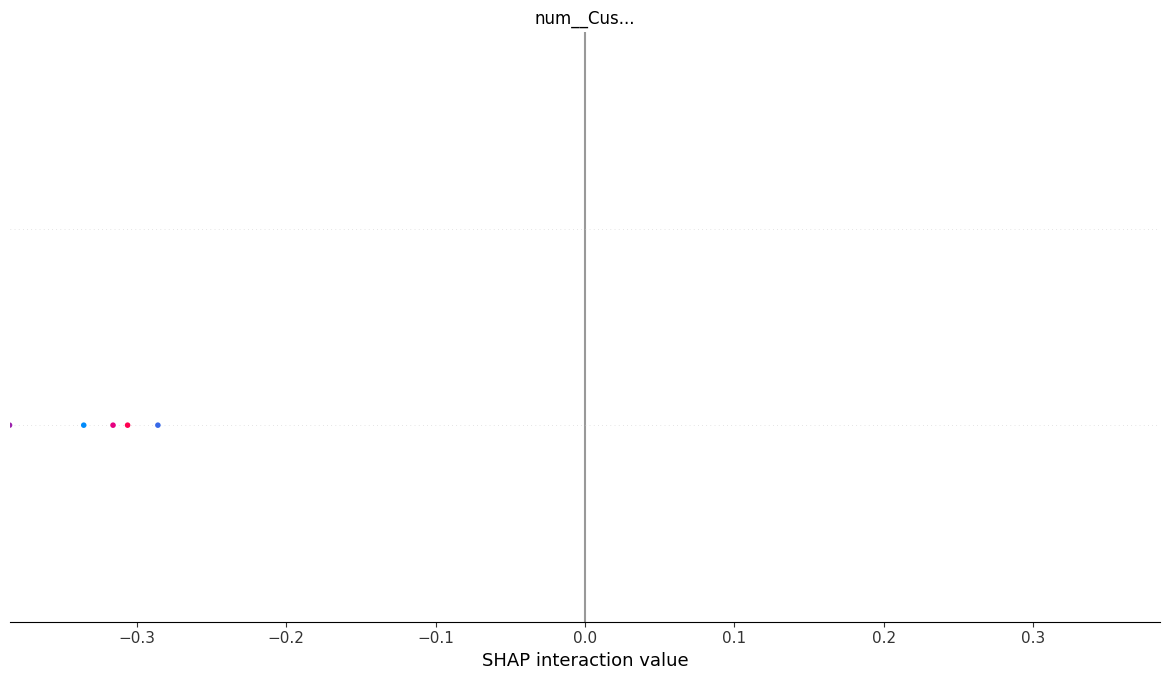

SHAP failed with error: The waterfall plot can currently only plot a single explanation, but a matrix of explanations (shape (16, 2)) was passed! Perhaps try `shap.plots.waterfall(shap_values[0])` or for multi-output models, try `shap.plots.waterfall(shap_values[0, 0])`.


In [13]:
print("Generating SHAP plots...")

X_train_transformed = best_model.named_steps['pre'].transform(X_train)
X_test_transformed = best_model.named_steps['pre'].transform(X_test)
feature_names_transformed = best_model.named_steps['pre'].get_feature_names_out()
classifier = best_model.named_steps['clf']

shap_input = X_test_transformed[:5]

try:
    if isinstance(classifier, (RandomForestClassifier, XGBClassifier)):
        explainer = shap.TreeExplainer(classifier)
        shap_values = explainer.shap_values(shap_input)

        # Handle binary classification
        if isinstance(shap_values, list) and len(shap_values) == 2:
            shap_values_to_plot = shap_values[1]
            base_val = explainer.expected_value[1]
        else:
            shap_values_to_plot = shap_values
            base_val = explainer.expected_value

        # Summary plot
        shap.summary_plot(shap_values_to_plot, shap_input, feature_names=feature_names_transformed)

        # Waterfall plot (only first sample)
        shap.plots.waterfall(shap.Explanation(
            values=shap_values_to_plot[0],
            base_values=base_val,
            data=shap_input[0],
            feature_names=feature_names_transformed
        ))

    else:
        print("SHAP skipped: KernelExplainer is too slow for LogisticRegression.")
        if hasattr(classifier, 'coef_'):
            importance = np.abs(classifier.coef_[0])
            feat_imp_df = pd.DataFrame({
                'Feature': feature_names_transformed,
                'Importance': importance
            }).sort_values(by='Importance', ascending=False)

            plt.figure(figsize=(10, 6))
            sns.barplot(data=feat_imp_df.head(10), x='Importance', y='Feature')
            plt.title('Top 10 Logistic Regression Feature Importances')
            plt.tight_layout()
            plt.show()
except Exception as e:
    print(f"SHAP failed with error: {e}")


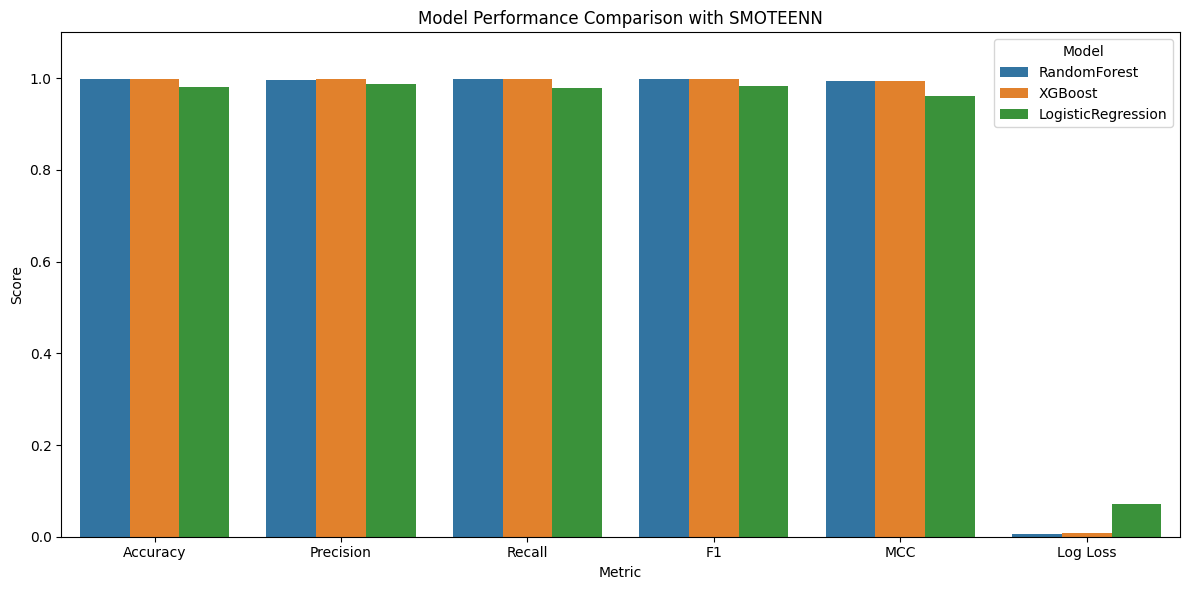

In [10]:
# Model Comparison Plot
results_df = pd.DataFrame(results)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'MCC', 'Log Loss']
melted_df = results_df.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=melted_df, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison with SMOTEENN')
plt.ylim(0, 1.1)
plt.legend(title='Model')
plt.tight_layout()
plt.show()
